In [1]:
from torch import nn
import torch
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

import xarray as xr
import time

In [2]:
plt.rcParams.update({'font.size': 22})

# define functions to calculate CKA

In [40]:
def unbiased_HSIC(K, L):
  #Computes an unbiased estimator of HISC.

  #create the unit **vector** filled with ones
    n = K.shape[0]
    ones = np.ones(shape=(n))

  #fill the diagonal entries with zeros 
    np.fill_diagonal(K, val=0) #this is now K_tilde 
    np.fill_diagonal(L, val=0) #this is now L_tilde

  #first part in the square brackets
    trace = np.trace(np.dot(K, L))

  #middle part in the square brackets
    nominator1 = np.dot(np.dot(ones.T, K), ones)
    nominator2 = np.dot(np.dot(ones.T, L), ones)
    denominator = (n-1)*(n-2)
    middle = np.dot(nominator1, nominator2) / denominator
  
  
  #third part in the square brackets
    multiplier1 = 2/(n-2)
    multiplier2 = np.dot(np.dot(ones.T, K), np.dot(L, ones))
    last = multiplier1 * multiplier2

  #complete equation
    unbiased_hsic = 1/(n*(n-3)) * (trace + middle - last)

    return unbiased_hsic

In [3]:
def CKA(X, Y):
    
    nominator = unbiased_HSIC(np.dot(X, X.T), np.dot(Y, Y.T))
    denominator1 = unbiased_HSIC(np.dot(X, X.T), np.dot(X, X.T))
    denominator2 = unbiased_HSIC(np.dot(Y, Y.T), np.dot(Y, Y.T))

    cka = nominator/np.sqrt(denominator1*denominator2)

    return cka

# define and load trained models

In [4]:
class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels, padding = 1),
                    torch.nn.SELU(),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels, padding = 1),
                    torch.nn.SELU(),
                    torch.nn.BatchNorm2d(out_channels),
                )
        return block
    
    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding = 1),
                    torch.nn.SELU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding = 1),
                    torch.nn.SELU(),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.Upsample(scale_factor=2, mode='nearest'),
                    torch.nn.Conv2d(kernel_size=3, in_channels=out_channels, out_channels=out_channels, padding = 1),
                    torch.nn.SELU(),
                    torch.nn.BatchNorm2d(out_channels),
#                     torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) ## padding?
                    )
            return  block
    
    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding = 1),
                    torch.nn.SELU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding = 1),
                    torch.nn.SELU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
                    torch.nn.SELU(),
                    torch.nn.BatchNorm2d(out_channels),
                    )
            return  block
    
    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=32)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(32, 64)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(64, 128)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        # Bottleneck
        self.bottleneck = torch.nn.Sequential(
                            torch.nn.Conv2d(kernel_size=3, in_channels=128, out_channels=128, padding = 1),
                            torch.nn.SELU(),
                            torch.nn.BatchNorm2d(128),
                            torch.nn.Conv2d(kernel_size=3, in_channels=128, out_channels=128, padding = 1),
                            torch.nn.SELU(),
                            torch.nn.BatchNorm2d(128),
                            torch.nn.Upsample(scale_factor=2, mode='nearest'),
                            torch.nn.Conv2d(kernel_size=3, in_channels=128, out_channels=128, padding = 1),
                            torch.nn.SELU(),
                            torch.nn.BatchNorm2d(128),
                            )
        # Decode
        self.conv_decode3 = self.expansive_block(256, 128, 64)
        self.conv_decode2 = self.expansive_block(128, 64, 32)
        self.final_layer = self.final_block(64, 32, out_channel)
        
    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)
    
    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)
        # Decode
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3, crop=True) ### false should work?
        cat_layer2 = self.conv_decode3(decode_block3)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2, crop=True)
        cat_layer1 = self.conv_decode2(decode_block2)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1, crop=True)
        final_layer = self.final_layer(decode_block1)
        return  final_layer

In [5]:
modelpre = UNet(in_channel = 1, out_channel = 1)
modelpre.load_state_dict(torch.load('../CNN_surface/basic_models/vort_Unet_mae_nSST'))


modelpre10000 = UNet(in_channel = 1, out_channel = 1)
modelpre10000.load_state_dict(torch.load('../CNN_LLCsummer/models/trains_dhruv'))


modelrand10000 = UNet(in_channel = 1, out_channel = 1)
modelrand10000.load_state_dict(torch.load('../CNN_LLCsummer/models/trains_rand'))


modelprefull= UNet(in_channel = 1, out_channel = 1)
modelprefull.load_state_dict(torch.load('../CNN_LLCsummer/models/trains_dhruv_full'))


modelrandfull = UNet(in_channel = 1, out_channel = 1)
modelrandfull.load_state_dict(torch.load('../CNN_LLCsummer/models/trains_rand_full'))


<All keys matched successfully>

# load test input

In [11]:
Eta_test = np.load('../CNN_LLCsummer/dataCollection4/Eta_r3_winter.npy')
Eta_test_reshape =  np.reshape(np.array(np.split(np.array(np.split(Eta_test[:40,16:784,16:784], 12, axis=2)), 12, axis=2)), (12*12*40, 64, 64))
input1 =  torch.tensor(np.expand_dims(Eta_test_reshape_nonan[:100,:,:], axis=1))

# get outputs from different layers of different models

In [ ]:
def layers_output(model, input_data):
    model.eval()
    output1 = model.layer_output(input_data, 1).detach().numpy()
    output1 = output1.reshape((-1, np.product(output1.shape[1:])))
    
    output2 = model.layer_output(input_data, 2).detach().numpy()
    output2 = output2.reshape((-1, np.product(output2.shape[1:])))

    output3 = model.layer_output(input_data, 3).detach().numpy()
    output3 = output3.reshape((-1, np.product(output3.shape[1:])))

    output4 = model.layer_output(input_data, 4).detach().numpy()
    output4 = output4.reshape((-1, np.product(output4.shape[1:])))

    output5 = model.layer_output(input_data, 5).detach().numpy()
    output5 = output5.reshape((-1, np.product(output5.shape[1:])))

    output6 = model.layer_output(input_data, 6).detach().numpy()
    output6 = output6.reshape((-1, np.product(output6.shape[1:])))
    
    return [output1, output2, output3, output4, output5, output6]

In [16]:
output_pre = layers_output(modelpre, input1)  
output_pre10000 = layers_output(modelpre10000, input1)  
output_rand10000 = layers_output(modelrand10000, input1)  
output_prefull = layers_output(modelprefull, input1)  
output_randfull = layers_output(modelrandfull, input1)  

# get CKA between different models

In [18]:
result_pre_pre10000 = np.zeros(shape=(6, 6))
for i in range(6):
    for j in range(6):
        result_pre_pre10000[i, j] = CKA(output_pre[i], output_pre10000[j])

In [19]:
result_pre10000_rand10000 = np.zeros(shape=(6, 6))
for i in range(6):
    for j in range(6):
        result_pre10000_rand10000[i, j] = CKA(output_pre10000[i], output_rand10000[j])

In [20]:
result_prefull_randfull = np.zeros(shape=(6, 6))
for i in range(6):
    for j in range(6):
        result_prefull_randfull[i, j] = CKA(output_prefull[i], output_randfull[j])

In [21]:
result_pre_prefull = np.zeros(shape=(6, 6))
for i in range(6):
    for j in range(6):
        result_pre_prefull[i, j] = CKA(output_pre[i], output_prefull[j])

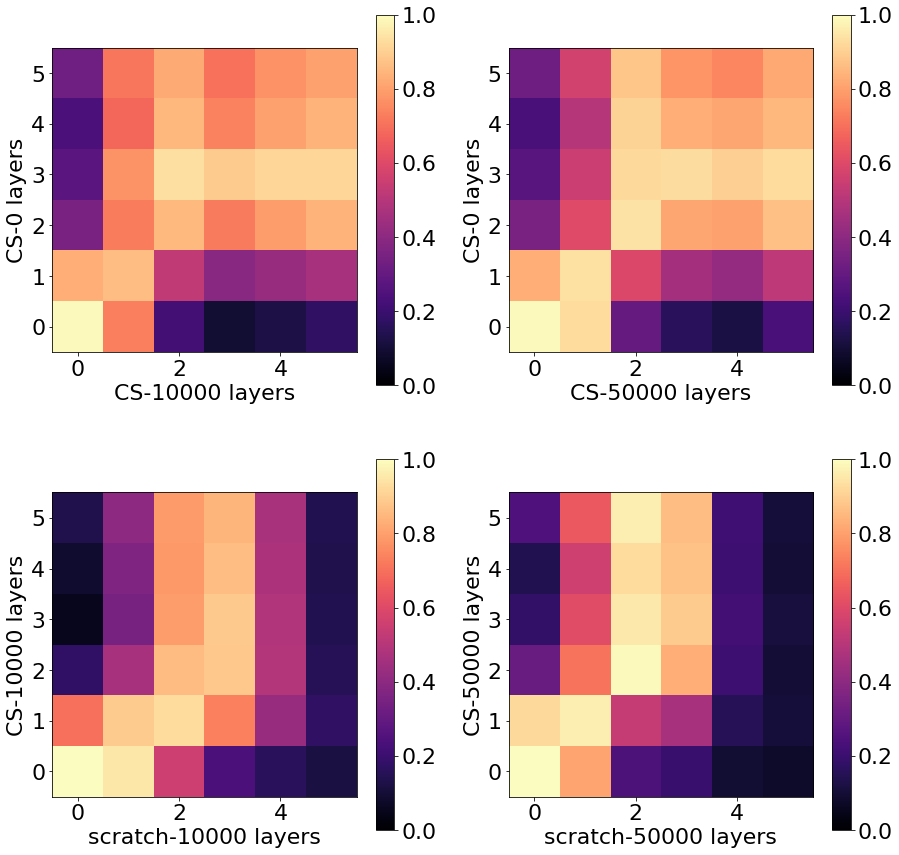

In [61]:
plt.figure(figsize=(15, 15))

plt.subplot(221)
plt.imshow(result_pre_pre10000, cmap='magma', vmin=0.0,vmax=1.0)
plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel('CS-10000 layers')
plt.ylabel('CS-0 layers')


plt.subplot(222)
plt.imshow(result_pre_prefull, cmap='magma', vmin=0.0,vmax=1.0)
plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel('CS-50000 layers')
plt.ylabel('CS-0 layers')



plt.subplot(223)
plt.imshow(result_pre10000_rand10000, cmap='magma', vmin=0.0,vmax=1.0)
plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel('scratch-10000 layers')
plt.ylabel('CS-10000 layers')



plt.subplot(224)
plt.imshow(result_prefull_randfull, cmap='magma', vmin=0.0,vmax=1.0)
plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel('scratch-50000 layers')
plt.ylabel('CS-50000 layers')

plt.savefig("fig21-1.pdf", bbox_inches = "tight")